## Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from warnings import filterwarnings
from tqdm.notebook import tqdm_notebook
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras import Model
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
import random

2024-02-05 14:16:45.343689: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 14:16:45.343740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 14:16:45.345165: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
filterwarnings('ignore')

🔑**Note: The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg**

- [age] is an integer from 0 to 116, indicating the age
- [gender] is either 0 (male) or 1 (female)
- [race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
- [date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [3]:
gender_list = ["Male", "Female"]
race_list = ["White","Black", "Asian", "Indian", "Others"]

## Plotting Random Images

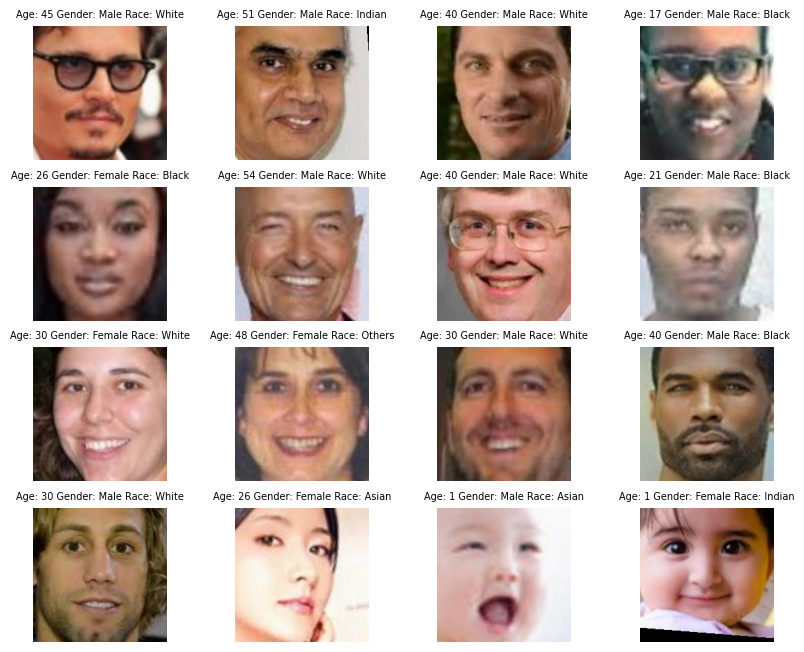

In [4]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (10, 8))
all_images = os.listdir(r"/kaggle/input/utkface-new/UTKFace")
for i in range(4):
    for j in range(4):
        rand_img_path = random.choice(all_images)
        age, gender, race, _ = rand_img_path.split("_")
        rand_img = load_img(os.path.join(r"/kaggle/input/utkface-new/UTKFace", rand_img_path))
        axes[i][j].axis('off')
        axes[i][j].imshow(img_to_array(rand_img)/255.)
        axes[i][j].set_title(f"Age: {int(age)} Gender: {gender_list[int(gender)]} Race: {race_list[int(race)]}", fontsize = 7)

## Creating the dataset with images and labels

❗For some of the images, the race value is not present

In [5]:
def get_data(img_size:tuple[int] = 224):
    global all_images
    images = []
    labels = []
    for img in tqdm_notebook(all_images):
        try:
            age, gender, race, _ = img.split("_")   # If you can't find the race, just skip it
        except:
            continue
            
        my_img = load_img(os.path.join(r"/kaggle/input/utkface-new/UTKFace", img), 
                          target_size = (img_size, img_size))
        images.append(img_to_array(my_img))
        labels.append(np.array([int(age), int(gender), int(race)]))
        
        
    return np.array(images), np.array(labels)

In [6]:
images, labels = get_data(img_size = 128)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [7]:
ages = labels[:, 0]
genders = labels[:, 1]
races = labels[:, 2]

In [8]:
images.shape, ages.shape, genders.shape, races.shape

((23705, 128, 128, 3), (23705,), (23705,), (23705,))

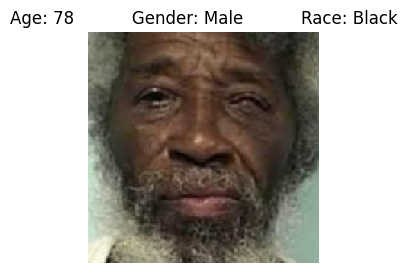

In [9]:
plt.figure(figsize = (3, 3))
rand_index = random.randint(0, images.shape[0])
plt.imshow(images[rand_index]/255.)
plt.axis('off')

plt.title(f"Age: {ages[rand_index]} \
          Gender: {gender_list[genders[rand_index]]} \
          Race: {race_list[races[rand_index]]}");

### using tf.data API for faster training

In [10]:
input_data = tf.data.Dataset.from_tensor_slices(images)
output_labels = tf.data.Dataset.from_tensor_slices((ages, genders, races))
data = tf.data.Dataset.zip((input_data, output_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)))>

- Making train-test split

In [11]:
data = data.shuffle(buffer_size = 10)
total_size = len(data)
train_size = int(0.75 * total_size)

train_data = data.take(train_size)
test_data = data.skip(train_size)


## Modelling Experiments

In [12]:
def model_ckpt(model_name):
    return ModelCheckpoint(
        filepath = f"./{model_name}",
        monitor = 'val_loss',
        save_best_only = True
    )

#### EfficientNet

In [13]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B2, preprocess_input

In [14]:
effnet_model = EfficientNetV2B2(include_top = False, input_shape = (128, 128, 3))
effnet_model.trainable = False

In [15]:
print(f"Total layers: {len(effnet_model.layers)}")

Total layers: 349


In [17]:
inputs = Input(shape = (128, 128, 3), dtype = tf.float32)
x = preprocess_input(inputs)
x = effnet_model(x)
x = Flatten(name = "Flatten_layer")(x)
x = Dropout(rate = 0.3)(x)

output_age = Dense(units = 128, activation = 'relu', name = 'Age_dense')(x)
output_age = Dropout(rate = 0.3)(output_age)
output_age = Dense(units = 1, activation = 'relu', name = "Age")(output_age)

output_gender = Dense(units = 128, activation = 'relu', name = 'Gender_dense')(x)
output_gender = Dropout(rate = 0.3)(output_gender)
output_gender = Dense(units = 1, activation = 'sigmoid', name = "Gender")(output_gender)

output_race = Dense(units = 128, activation = 'relu', name = 'Race_dense')(x)
output_race = Dropout(rate = 0.3)(output_race)
output_race = Dense(units = len(race_list), activation = 'softmax', name = "Race")(output_race)

model1 = Model(inputs = inputs, outputs = [output_age, output_gender, output_race])

- The model architecture 

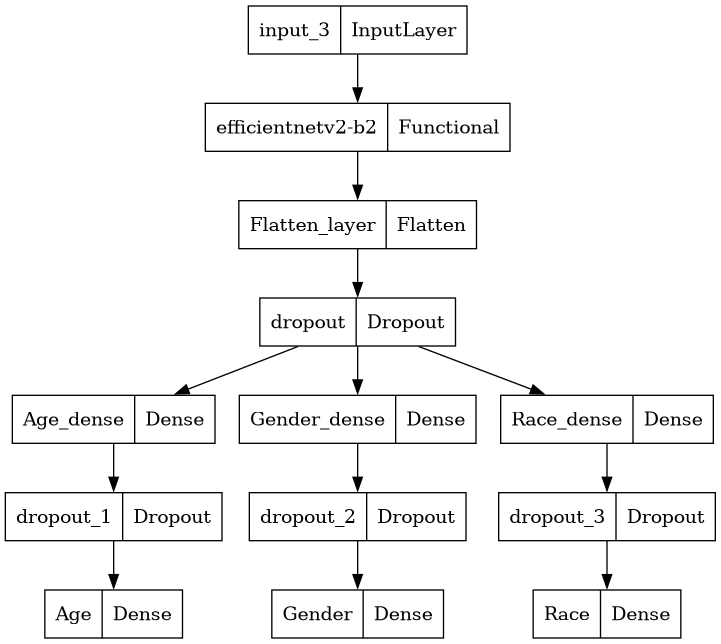

In [18]:
plot_model(model1)

In [19]:
model1.compile(
    loss = ['mae', 'binary_crossentropy', 'sparse_categorical_crossentropy'],
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002),
    metrics = ['mae', 'accuracy']
)

In [20]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 efficientnetv2-b2 (Functio  (None, 4, 4, 1408)           8769374   ['input_3[0][0]']             
 nal)                                                                                             
                                                                                                  
 Flatten_layer (Flatten)     (None, 22528)                0         ['efficientnetv2-b2[0][0]']   
                                                                                                  
 dropout (Dropout)           (None, 22528)                0         ['Flatten_layer[0][0]']   

In [21]:
model1_hist = model1.fit(train_data, epochs = 15, validation_data = test_data, callbacks = [model_ckpt("effnet")])

Epoch 1/15


2024-02-05 14:19:25.963433: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-b2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707142769.907643    1146 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


555/555 [==============================] - 86s 130ms/step - loss: 10.7656 - Age_loss: 9.4061 - Gender_loss: 0.3254 - Race_loss: 1.0341 - Age_mae: 9.4061 - Age_accuracy: 0.0141 - Gender_mae: 0.1940 - Gender_accuracy: 0.8574 - Race_mae: 1.2371 - Race_accuracy: 0.6206 - val_loss: 8.6433 - val_Age_loss: 7.5842 - val_Gender_loss: 0.2538 - val_Race_loss: 0.8053 - val_Age_mae: 7.5842 - val_Age_accuracy: 0.0064 - val_Gender_mae: 0.1604 - val_Gender_accuracy: 0.8929 - val_Race_mae: 1.2440 - val_Race_accuracy: 0.7129
Epoch 2/15
555/555 [==============================] - 64s 116ms/step - loss: 9.0326 - Age_loss: 7.9691 - Gender_loss: 0.2534 - Race_loss: 0.8102 - Age_mae: 7.9691 - Age_accuracy: 0.0080 - Gender_mae: 0.1540 - Gender_accuracy: 0.8910 - Race_mae: 1.2384 - Race_accuracy: 0.7142 - val_loss: 8.0051 - val_Age_loss: 7.0016 - val_Gender_loss: 0.2385 - val_Race_loss: 0.7650 - val_Age_mae: 7.0016 - val_Age_accuracy: 0.0022 - val_Gender_mae: 0.1419 - val_Gender_accuracy: 0.9004 - val_Race_mae:

### Evaluating the model on Test data

In [22]:
model1.evaluate(test_data)

186/186 [==============================] - 6s 28ms/step - loss: 7.2348 - Age_loss: 6.3023 - Gender_loss: 0.2500 - Race_loss: 0.6825 - Age_mae: 6.3023 - Age_accuracy: 0.0010 - Gender_mae: 0.1044 - Gender_accuracy: 0.9120 - Race_mae: 1.2457 - Race_accuracy: 0.7828


[7.23480749130249,
 6.3022966384887695,
 0.25004008412361145,
 0.6824694871902466,
 6.3022966384887695,
 0.001009251456707716,
 0.10437626391649246,
 0.9120269417762756,
 1.245651364326477,
 0.7828426957130432]

### Model performance

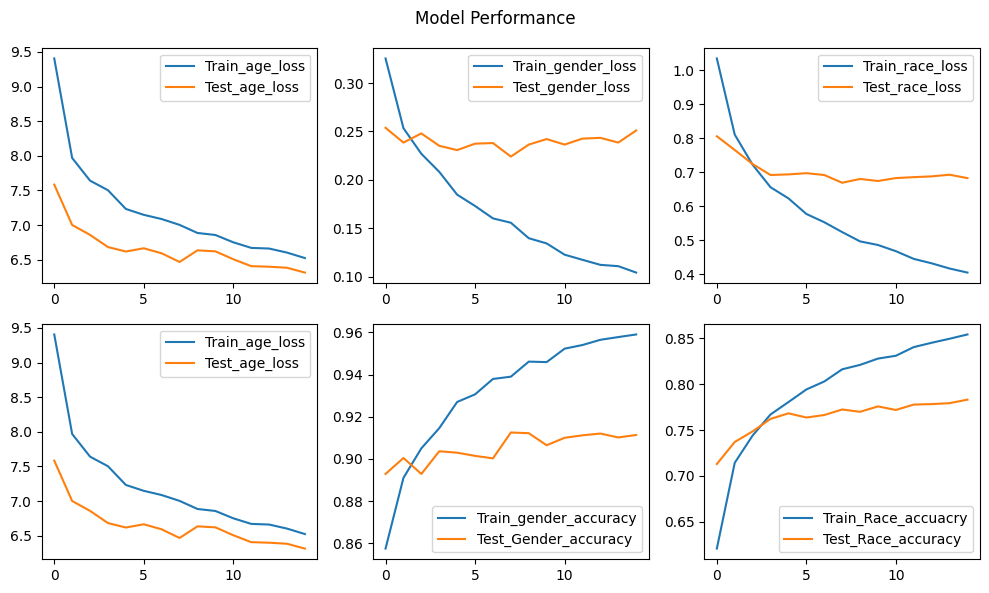

In [23]:
plt.figure(figsize = (10, 6))
plt.subplot(2, 3, 1)
plt.suptitle("Model Performance")
sns.lineplot(x = model1_hist.epoch, y =  model1_hist.history['Age_loss'], label = "Train_age_loss")
sns.lineplot(x = model1_hist.epoch, y =  model1_hist.history['val_Age_loss'], label = "Test_age_loss")
plt.subplot(2, 3, 2)
sns.lineplot(x = model1_hist.epoch, y = model1_hist.history['Gender_loss'], label = "Train_gender_loss")
sns.lineplot(x = model1_hist.epoch, y = model1_hist.history['val_Gender_loss'], label = "Test_gender_loss")
plt.subplot(2, 3, 3)
sns.lineplot(x = model1_hist.epoch, y = model1_hist.history['Race_loss'], label = "Train_race_loss")
sns.lineplot(x = model1_hist.epoch, y = model1_hist.history['val_Race_loss'], label = "Test_race_loss")
plt.subplot(2, 3, 4)
sns.lineplot(x = model1_hist.epoch, y =  model1_hist.history['Age_loss'], label = "Train_age_loss")
sns.lineplot(x = model1_hist.epoch, y =  model1_hist.history['val_Age_loss'], label = "Test_age_loss")
plt.subplot(2, 3, 5)
sns.lineplot(x = model1_hist.epoch, y = model1_hist.history['Gender_accuracy'],label = "Train_gender_accuracy")
sns.lineplot(x = model1_hist.epoch, y =  model1_hist.history['val_Gender_accuracy'], label = "Test_Gender_accuracy")
plt.subplot(2, 3, 6)
sns.lineplot(x = model1_hist.epoch, y = model1_hist.history['Race_accuracy'],label = "Train_Race_accuacry")
sns.lineplot(x = model1_hist.epoch, y =  model1_hist.history['val_Race_accuracy'], label = "Test_Race_accuracy")
plt.tight_layout()

### Prediction on random image

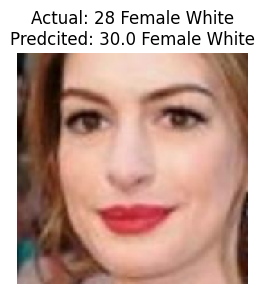

In [25]:
plt.figure(figsize = (3, 3))
rand_ind = random.randint(0, len(images))
pred = model1.predict(np.expand_dims(images[rand_ind], 0), verbose = 0)
pred_age = np.ceil(pred[0][0][0])
pred_gender = np.round(pred[1][0][0])
pred_race = np.argmax(pred[2], axis = 1)
plt.imshow(images[rand_ind]/255.)
plt.axis('off')
plt.title(f"Actual: {ages[rand_ind]} {gender_list[genders[rand_ind]]} {race_list[races[rand_ind]]}\nPredcited: {pred_age} {gender_list[int(pred_gender)]} {race_list[pred_race[0]]}")
plt.show()

In [36]:
!zip -r effnet.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/model.png (deflated 13%)
  adding: kaggle/working/effnet/ (stored 0%)
  adding: kaggle/working/effnet/keras_metadata.pb (deflated 96%)
  adding: kaggle/working/effnet/variables/ (stored 0%)
  adding: kaggle/working/effnet/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: kaggle/working/effnet/variables/variables.index (deflated 76%)
  adding: kaggle/working/effnet/saved_model.pb (deflated 91%)
  adding: kaggle/working/effnet/assets/ (stored 0%)
  adding: kaggle/working/effnet/fingerprint.pb (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
